# Optimización de Carteras de Inversion

## Evaluación y Optimización de Cartera de Inversiones

### Introducción:

Este proyecto realiza un análisis exhaustivo de una cartera de inversiones que incluye acciones del índice IPSA, haciendo uso de técnicas avanzadas en finanzas cuantitativas.

### Objetivo:

El núcleo del proyecto radica en la búsqueda de maximizar los rendimientos de la cartera, manteniendo a la par una minimización del riesgo asociado. Esto con el fin de determinar la distribución óptima del capital entre los diferentes activos.

### Proceso:

1. **Adquisición de Datos:** A partir de fuentes confiables, se recolectaron datos históricos de precios, esenciales para entender el comportamiento pasado de l
2. **Analisis Exploratorio:** Estudiar estadísticas descriptivas (media, mediana, desviación estándar, etc.).a3 acciones.
2. **Evaluación de Riesgo y Rendimiento:** Se calculan métricas esenciales, como la volatilidad y los rendimientos esperados para cada activo, ofreciendo una base sólida para las decisiones d4 inversión.
3. **Optimización:** Mediante el modelo de Markowitz, se establece la asignación óptima de activos en la cartera, equilibrando rendimie5to y riesgo.
4. **Comparativa con Benchmark:** La cartera optimizada es contrastada con el índice IPSA, proporcionando insights sobre su desempeño en relación al merca6o enEvaluación de desempeñoálisis Adicional:** Se integran herramientas adicionales, como el análisis de drawdown, para evaluar la robustez de la cartera frente a escen rios de m
7. **Implementacion y Monitoreo**ercado adversos.

### Conclusión:

La eficiente construcción y administración de una cartera no solo depende de técnicas cuantitativas, sino también de la comparación con benchmarks y del monitoreo constante del mercado.


In [1]:
# Carga de Librerias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import risk_models
from pypfopt import expected_returns
import cvxpy as cp
from scipy.optimize import minimize

## Definición de Objetivos
- Maximizar rentabilidad y minimizar riesgo mediante la frontera eficiencia.

## Recolección y Preparación de Datos:

- Seleccionar los activos o instrumentos a incluir en la cartera.
- Obtener series históricas de precios o rendimientos.
- Limpiar y procesar los datos para asegurar que sean consistentes y confiables.
  

In [2]:
# Lista de tickers de las empresas IPSA

tickers =  ["SQM","BCH","BSANTANDER.SN","CENCOSUD.SN","COPEC.SN","ENELAM.SN","BCI.SN","CMPC.SN","FALABELLA.SN","ENELCHILE.SN",
            "COLBUN.SN","PARAUCO.SN","VAPORES.SN","AGUAS-A.SN","ANDINA-B.SN","CCU.SN","QUINENCO.SN","CENCOMALLS.SN","LTM.SN",
            "CONCHATORO.SN","ENTEL.SN","MALLPLAZA.SN","CAP.SN","ECL.SN","ITAUCL.SN","ORO-BLANCO.SN","IAM.SN","SMU.SN","RIPLEY.SN",
            "SONDA.SN"]

# Definimos la fecha de inicio y fin para los últimos 5 años
end_date = pd.Timestamp.today()
start_date = end_date - pd.DateOffset(years=5)

# Descargamos los datos
data = yf.download(tickers, start=start_date, end=end_date, interval="1wk")

# Seleccionamos solo el 'Adj Close' que es el precio de cierre ajustado
prices = data['Adj Close']


[*********************100%***********************]  30 of 30 completed


In [3]:
# Seleccionamos solo el 'Adj Close' y creamos una copia para trabajar en ella
prices = data['Adj Close'].copy()

# 1. Manejo de datos faltantes
missing_data = prices.isnull().sum()
print(f"Datos faltantes por ticker antes de la limpieza:\n{missing_data}\n")

# 2. Verificar valores duplicados
duplicates = prices[prices.index.duplicated()]
if len(duplicates) == 0:
    print("No hay valores duplicados.\n")
else:
    print(f"Valores duplicados encontrados:\n{duplicates}\n")
    prices.drop_duplicates(inplace=True)

# 3. Ordenar datos por fecha
prices.sort_index(inplace=True)

# 4. Verificar la existencia de outliers
for ticker in tickers:
    mean, std = prices[ticker].mean(), prices[ticker].std()
    outliers = prices[(prices[ticker] < mean - 3 * std) | (prices[ticker] > mean + 3 * std)][ticker]
    if not outliers.empty:
        print(f"Outliers detectados en {ticker}:\n{outliers}\n")

# 5. Llenar datos faltantes usando 'ffill' directamente
prices.ffill(inplace=True)

# Verificar si todavía hay datos faltantes
missing_data_after = prices.isnull().sum()
print(f"Datos faltantes por ticker después de la limpieza:\n{missing_data_after}\n")


Datos faltantes por ticker antes de la limpieza:
Ticker
AGUAS-A.SN       1
ANDINA-B.SN      1
BCH              0
BCI.SN           1
BSANTANDER.SN    1
CAP.SN           1
CCU.SN           1
CENCOMALLS.SN    1
CENCOSUD.SN      1
CMPC.SN          1
COLBUN.SN        1
CONCHATORO.SN    1
COPEC.SN         1
ECL.SN           1
ENELAM.SN        1
ENELCHILE.SN     1
ENTEL.SN         1
FALABELLA.SN     1
IAM.SN           1
ITAUCL.SN        0
LTM.SN           1
MALLPLAZA.SN     1
ORO-BLANCO.SN    1
PARAUCO.SN       1
QUINENCO.SN      1
RIPLEY.SN        1
SMU.SN           1
SONDA.SN         1
SQM              0
VAPORES.SN       1
dtype: int64

No hay valores duplicados.

Outliers detectados en COPEC.SN:
Date
2021-03-22    8948.146484
2021-04-12    9031.129883
Freq: 3W-MON, Name: COPEC.SN, dtype: float64

Outliers detectados en ENELAM.SN:
Date
2019-12-02    159.981400
2019-12-09    168.980347
2019-12-16    165.980682
2019-12-23    164.980789
2019-12-30    169.980209
2020-01-06    172.379929
2020-01

En el caso de "CENCOSHOPP.SN", hay 43 valores faltantes. Si este ticker no es esencial para tu análisis, la solución más sencilla y menos arriesgada es eliminarlo.

## Análisis Exploratorio:

- Estudiar estadísticas descriptivas (media, mediana, desviación estándar, etc.).
- Graficar y analizar tendencias y volatilidad de los activos.
- Correlación entre activos.

In [5]:
print(prices.describe())

Ticker  AGUAS-A.SN  ANDINA-B.SN         BCH        BCI.SN  BSANTANDER.SN  \
count   262.000000   262.000000  262.000000    262.000000     262.000000   
mean    199.033180  1735.602521   17.324049  20190.795898      34.627092   
std      52.767037   501.063159    3.481558   3730.477520       6.634079   
min     110.378342  1147.238770   11.491141  13767.041016      21.440294   
25%     158.727261  1384.770508   14.702828  17680.532715      30.158877   
50%     180.201202  1488.422363   16.531106  18932.704102      33.472107   
75%     254.845409  1942.172394   19.846611  21986.708496      38.937850   
max     298.989990  2983.859619   25.549999  29084.000000      49.000000   

Ticker        CAP.SN       CCU.SN  CENCOMALLS.SN  CENCOSUD.SN      CMPC.SN  \
count     262.000000   262.000000     262.000000   262.000000   262.000000   
mean     6189.069601  5320.445894    1039.900374  1289.572324  1606.972440   
std      1770.283431   627.363215     253.575447   336.619342   195.775736   
min

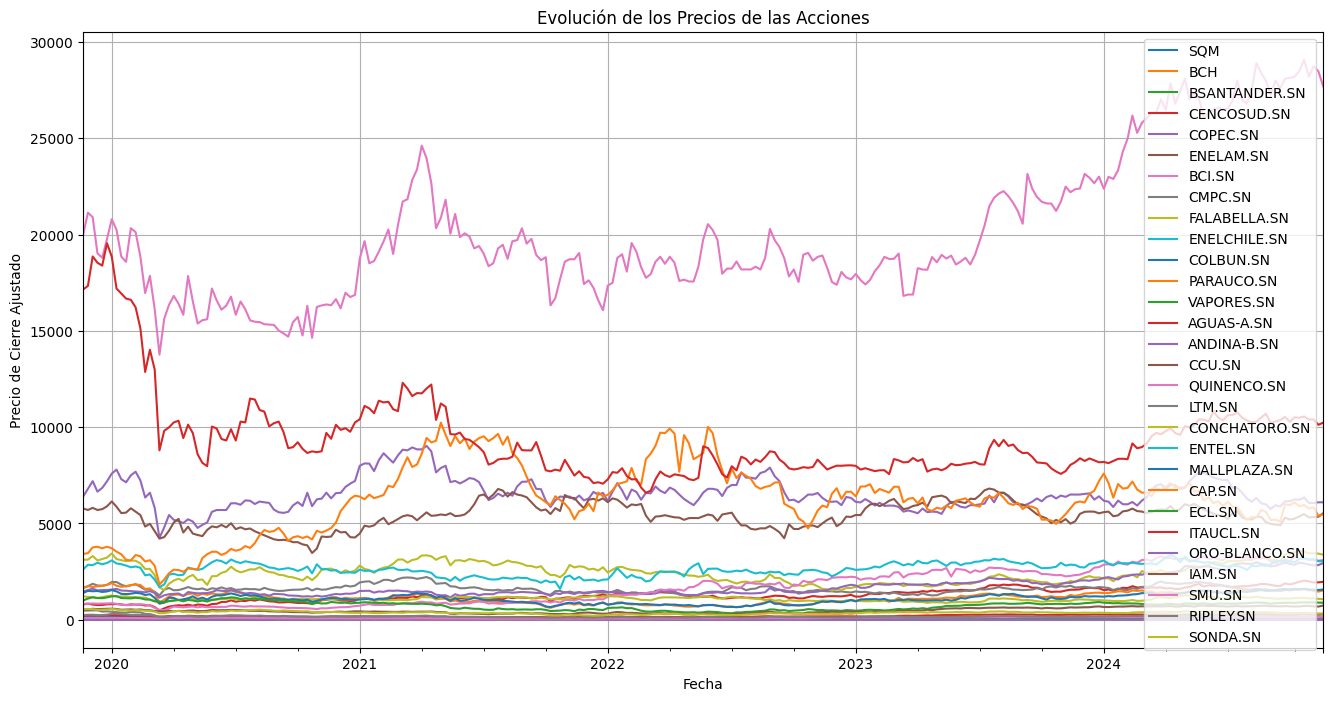

In [5]:
# Visualización de los Precios de las Acciones a lo Largo del Tiempo: ¿cómo han evolucionado los precios de las acciones a lo largo del tiempo?

plt.figure(figsize=(16,8))
for ticker in tickers:
    prices[ticker].plot(label=ticker)
plt.title('Evolución de los Precios de las Acciones')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado')
plt.legend()
plt.grid(True)
plt.show()



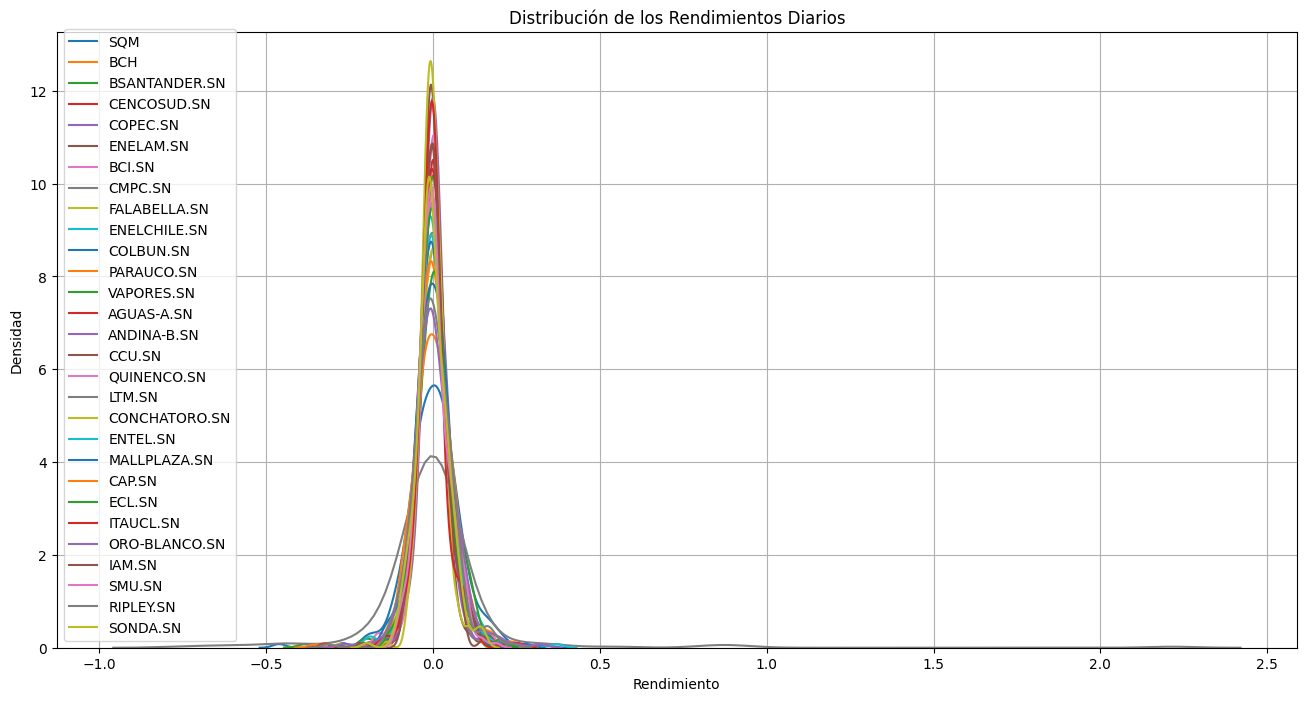

In [6]:
# Rendimientos Diarios: Calcularemos los rendimientos diarios y visualizaremos su distribución

returns = prices.pct_change().dropna()

plt.figure(figsize=(16,8))
for ticker in tickers:
    sns.kdeplot(returns[ticker], label=ticker)
plt.title('Distribución de los Rendimientos Diarios')
plt.xlabel('Rendimiento')
plt.ylabel('Densidad')
plt.legend()
plt.grid(True)
plt.show()



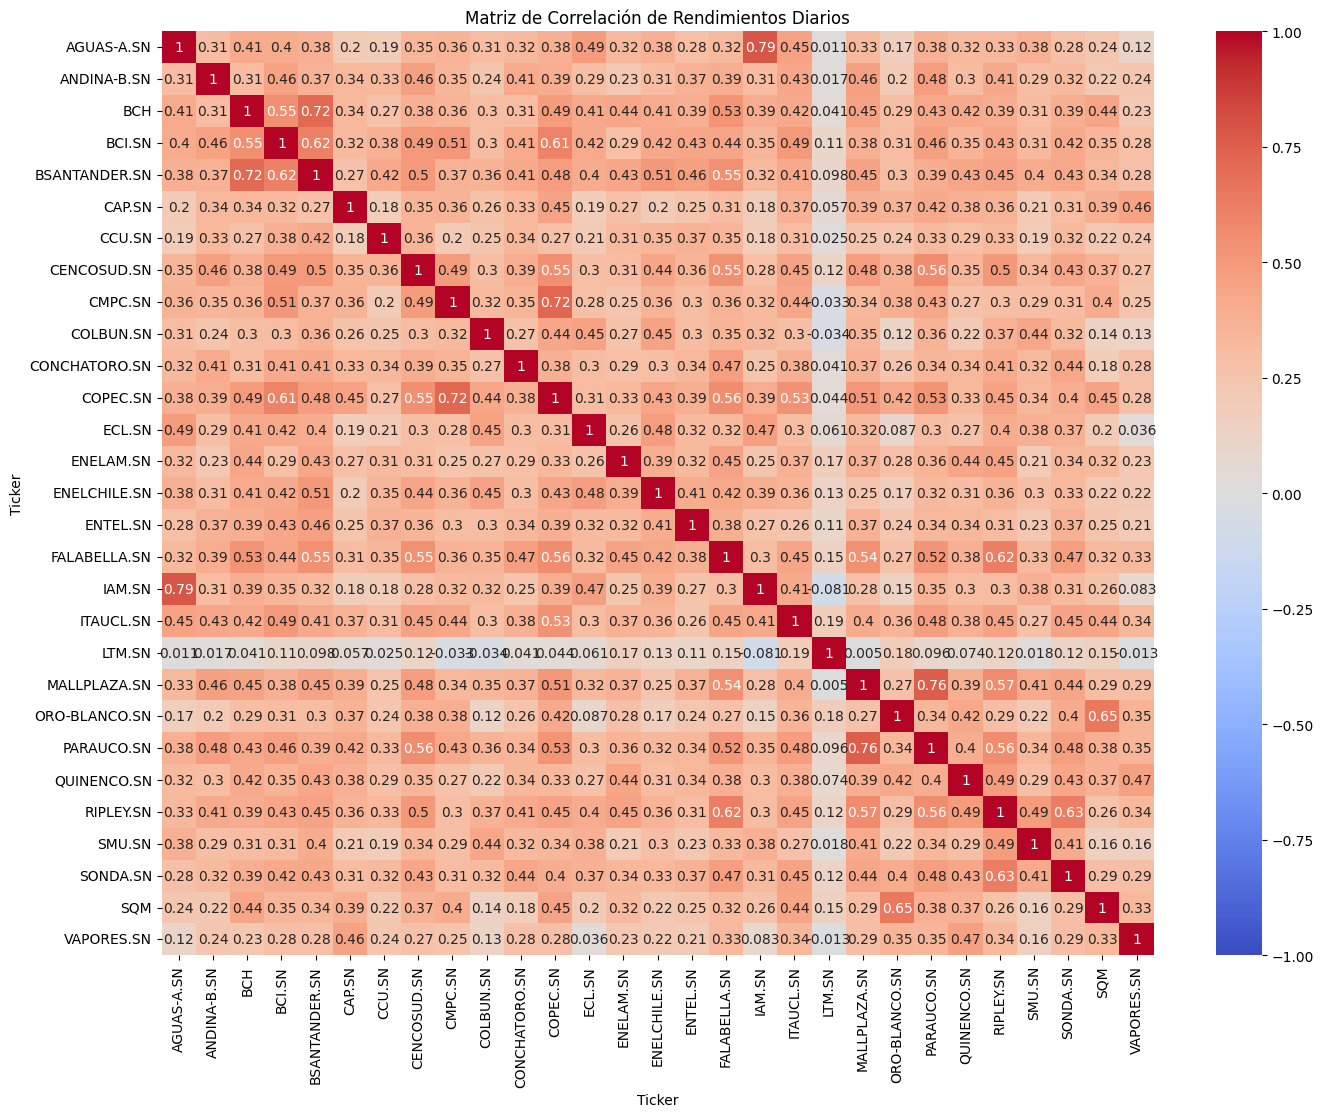

In [8]:
# Matriz de Correlación: ¿cómo se relacionan los rendimientos de las diferentes acciones entre sí?

correlation_matrix = returns.corr()

plt.figure(figsize=(16,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title('Matriz de Correlación de Rendimientos Diarios')
plt.show()


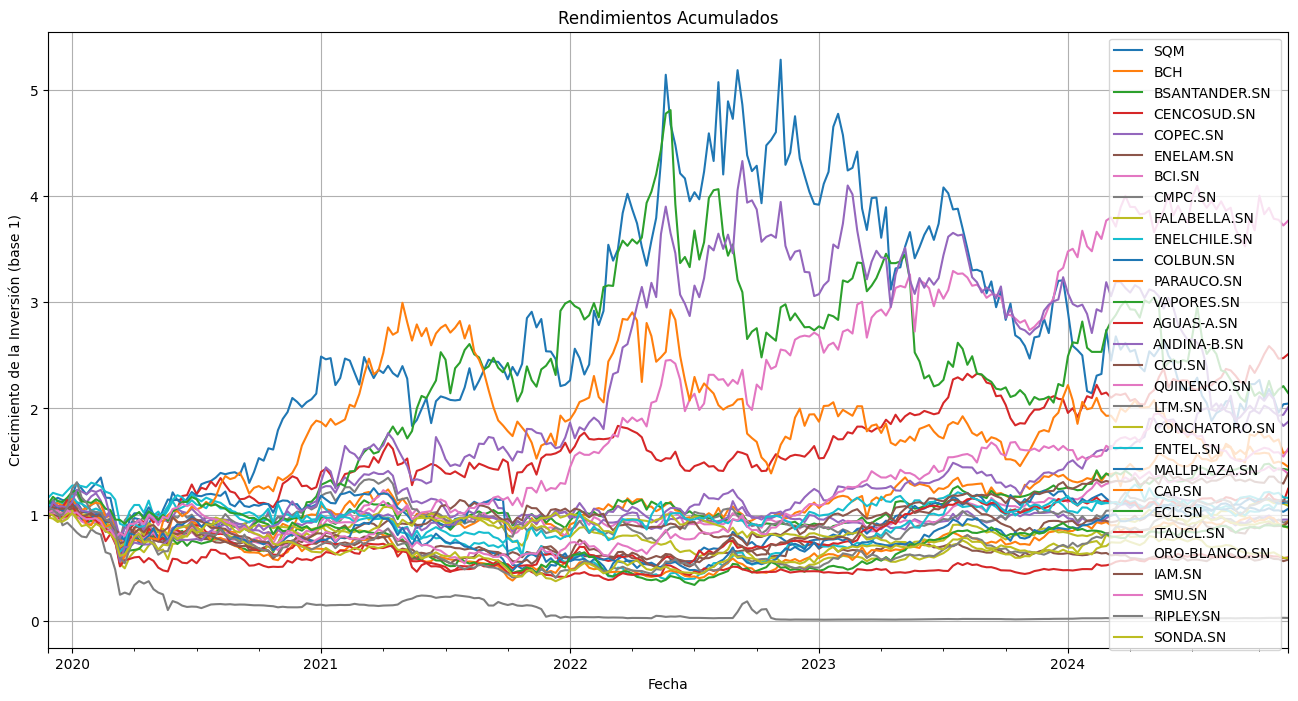

In [9]:
# Visualización de Rendimientos Acumulados: ¿cómo habría crecido una inversión en cada acción desde el inicio del período?

cumulative_returns = (1 + returns).cumprod()

plt.figure(figsize=(16,8))
for ticker in tickers:
    cumulative_returns[ticker].plot(label=ticker)
plt.title('Rendimientos Acumulados')
plt.xlabel('Fecha')
plt.ylabel('Crecimiento de la Inversión (base 1)')
plt.legend()
plt.grid(True)
plt.show()


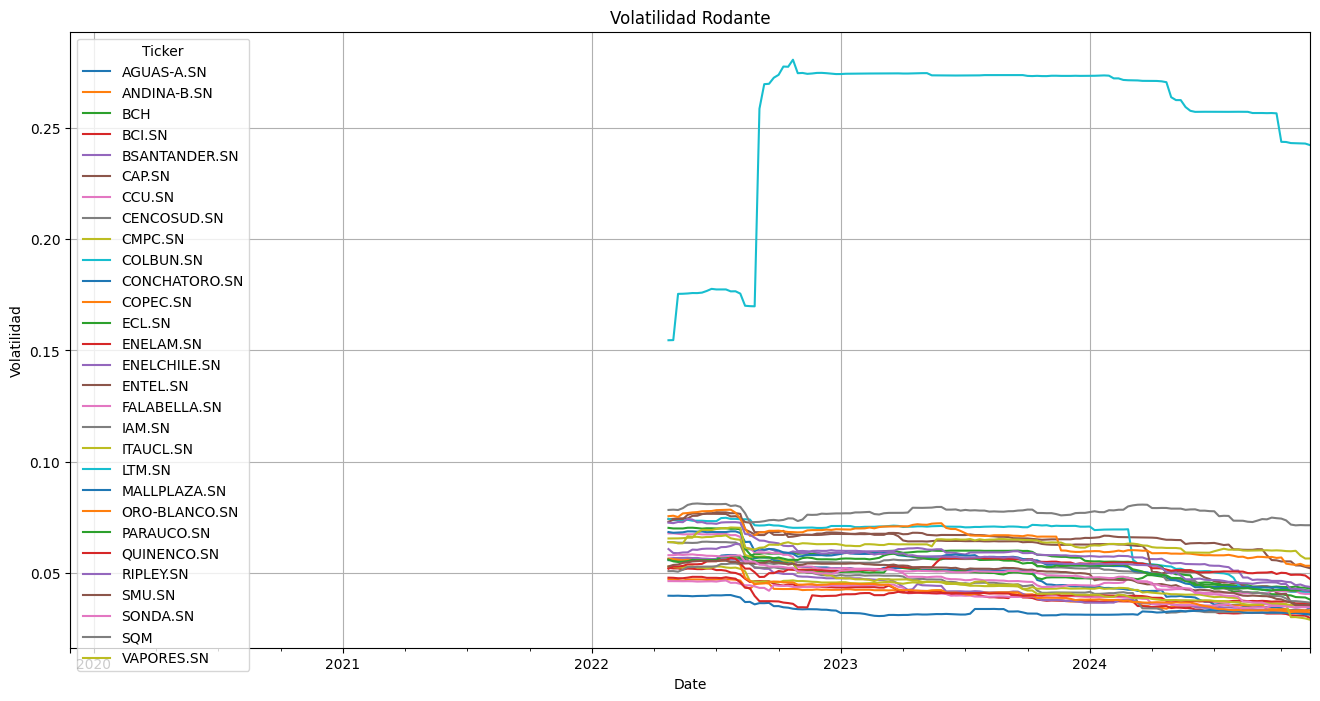

In [10]:
# Volatilidad Rodante: calcular y visualizar una medida rodante de la volatilidad, como la desviación estándar de los rendimientos en una ventana de tiempo específica.

rolling_volatility = returns.rolling(window=126).std()  # Por ejemplo, usando una ventana de 6 meses
rolling_volatility.plot(figsize=(16,8))
plt.title('Volatilidad Rodante')
plt.ylabel('Volatilidad')
plt.grid(True)
plt.show()

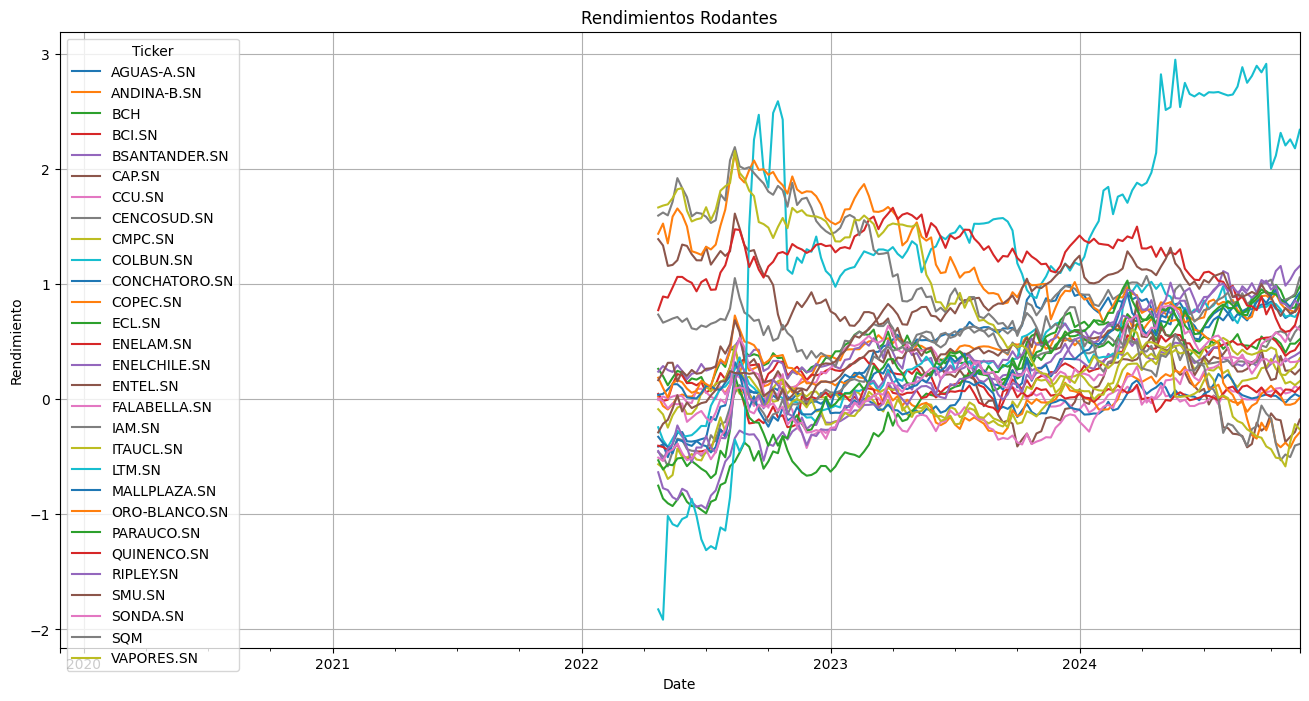

In [11]:
# Rendimientos Rodantes: visualización de los rendimientos acumulados en una ventana de tiempo específica

rolling_return = returns.rolling(window=126).sum()
rolling_return.plot(figsize=(16,8))
plt.title('Rendimientos Rodantes')
plt.ylabel('Rendimiento')
plt.grid(True)
plt.show()


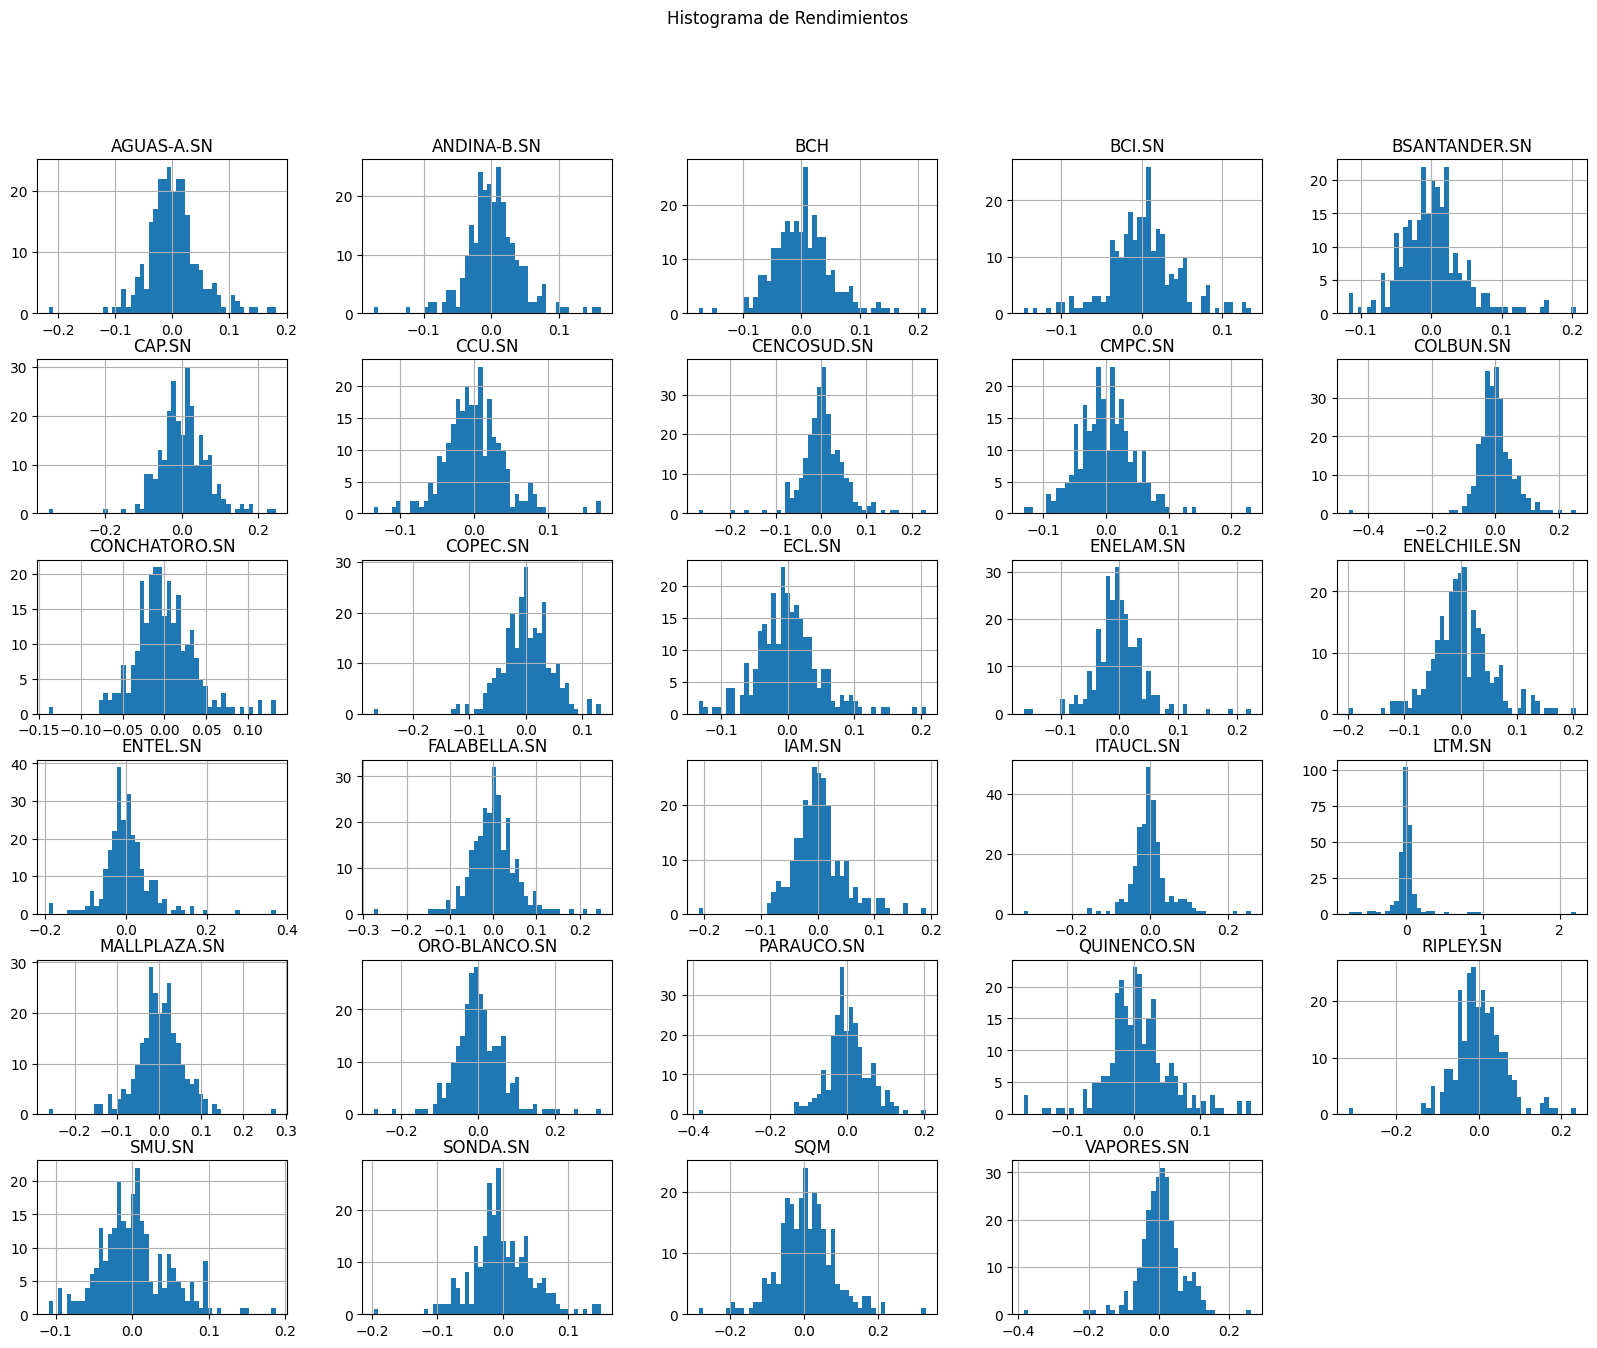

In [12]:
# Histogramas: Muestra la distribución de rendimientos para cada acción en particular. Es útil para identificar outliers o eventos extremos.

returns.hist(bins=50, figsize=(20,15))
plt.suptitle('Histograma de Rendimientos')
plt.show()

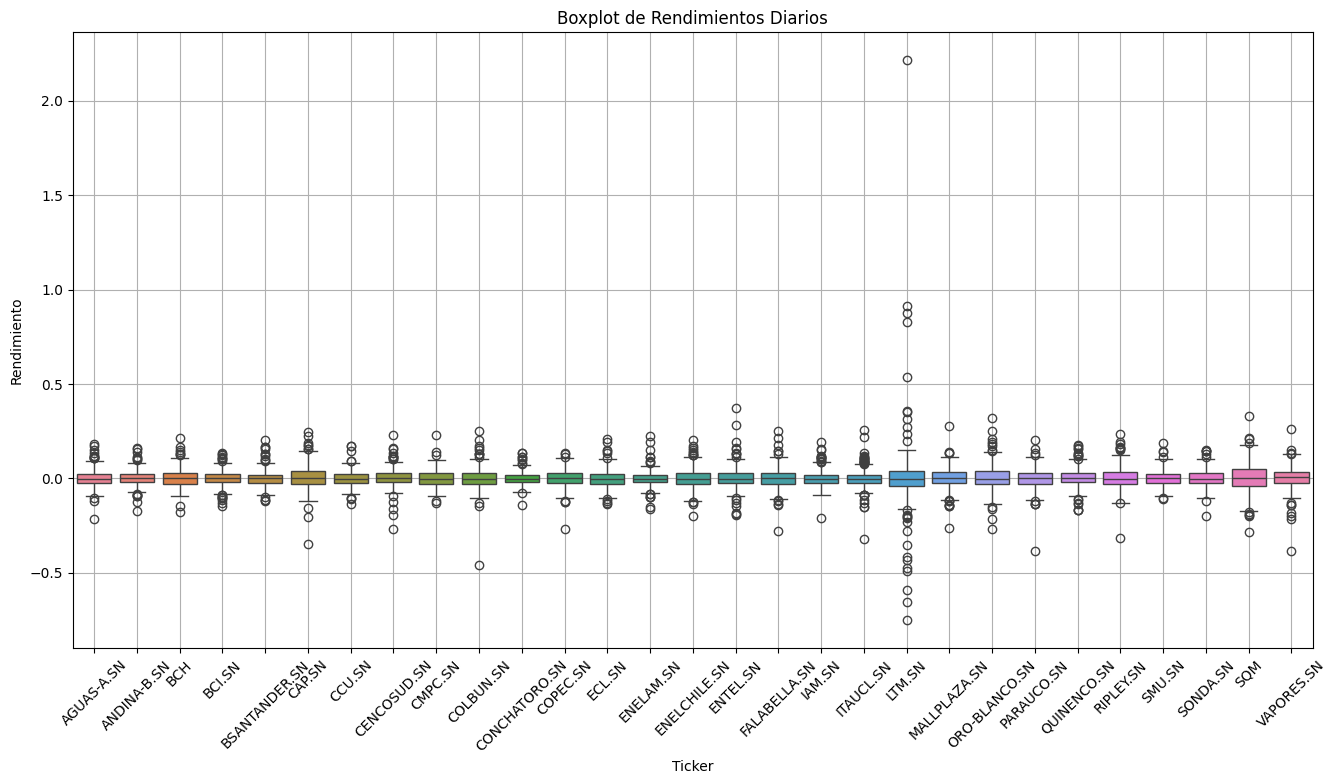

In [13]:
# Boxplots: muestra la dispersión y la presencia de valores atípicos de los rendimientos.

plt.figure(figsize=(16,8))
sns.boxplot(data=returns)
plt.title('Boxplot de Rendimientos Diarios')
plt.ylabel('Rendimiento')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


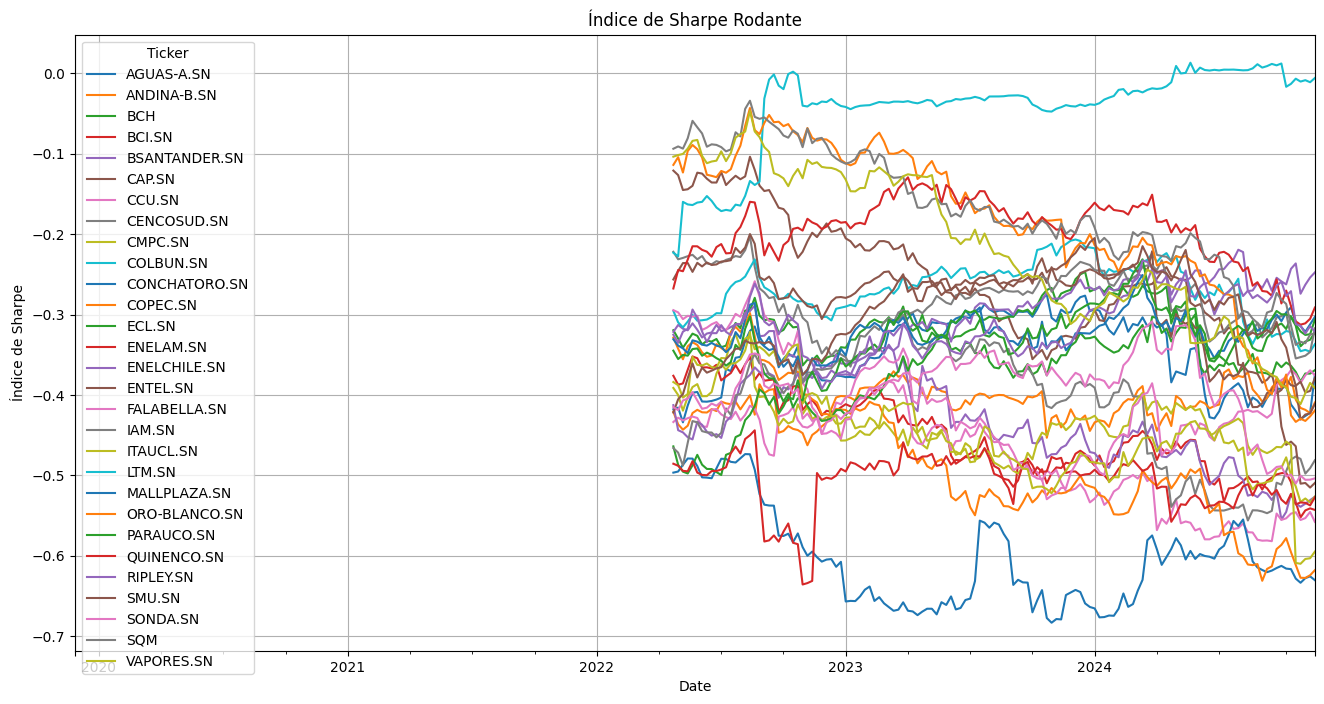

In [14]:
# Índice de Sharpe Rodante: Mide el rendimiento ajustado al riesgo. Puede calcularse de manera rodante para observar cómo ha evolucionado a lo largo del tiempo.

risk_free_rate = 0.02  # Asumiendo una tasa libre de riesgo del 2% 
rolling_sharpe = (returns.rolling(window=126).mean() - risk_free_rate) / returns.rolling(window=126).std()
rolling_sharpe.plot(figsize=(16,8))
plt.title('Índice de Sharpe Rodante')
plt.ylabel('Índice de Sharpe')
plt.grid(True)
plt.show()


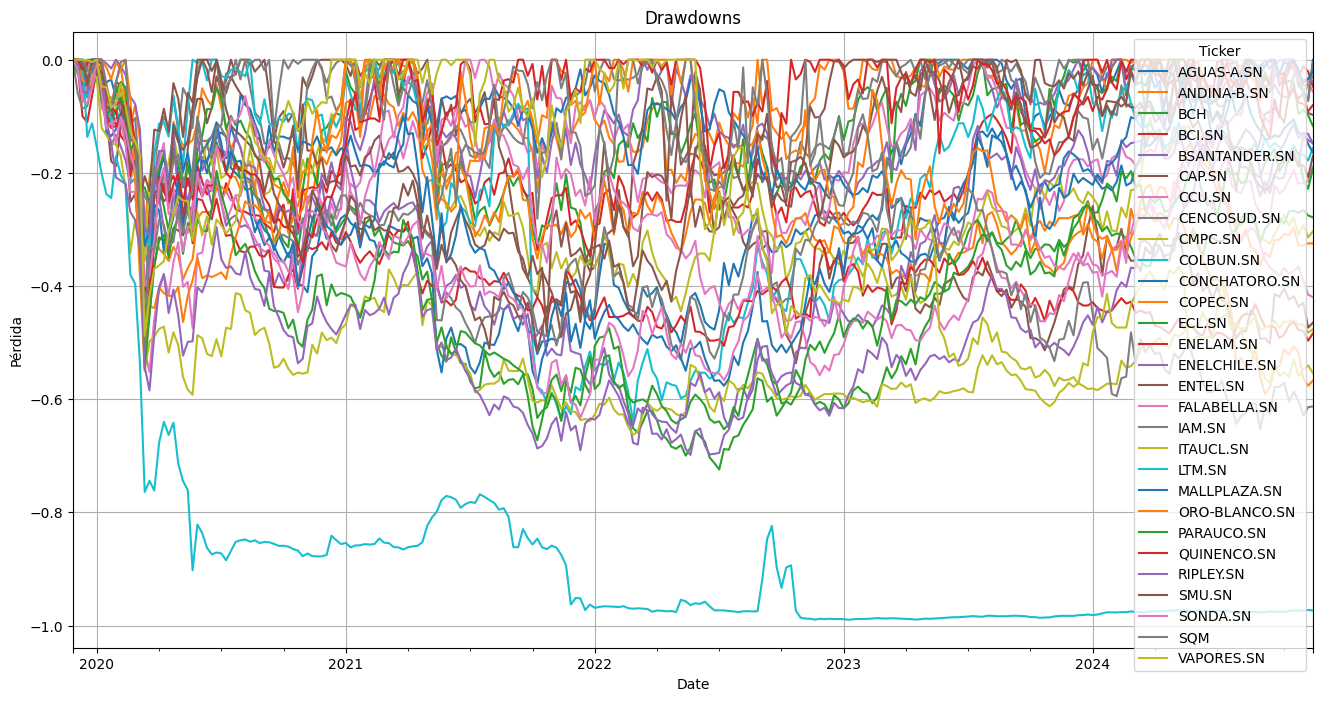

In [15]:
# Drawdowns: El drawdown mide la caída desde un pico hasta un mínimo. Es útil para entender la magnitud de las caídas máximas que podría experimentar una cartera o acción.

cumulative_returns = (1 + returns).cumprod()
rolling_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - rolling_max) / rolling_max
drawdown.plot(figsize=(16,8))
plt.title('Drawdowns')
plt.ylabel('Pérdida')
plt.grid(True)
plt.show()

## Modelado de Rendimientos y Riesgos:

- Estimar los rendimientos esperados (puede ser a través de la media histórica o modelos más avanzados).
- Calcular la matriz de covarianza.
- Estimar otros parámetros de riesgo si es necesario.

In [16]:
# Calcular los rendimientos semanales. Vamos a utilizar la media histórica de los rendimientos semanales.
weekly_returns = prices.pct_change().dropna()

# Estimar los rendimientos esperados (media histórica)
expected_weekly_returns = weekly_returns.mean()


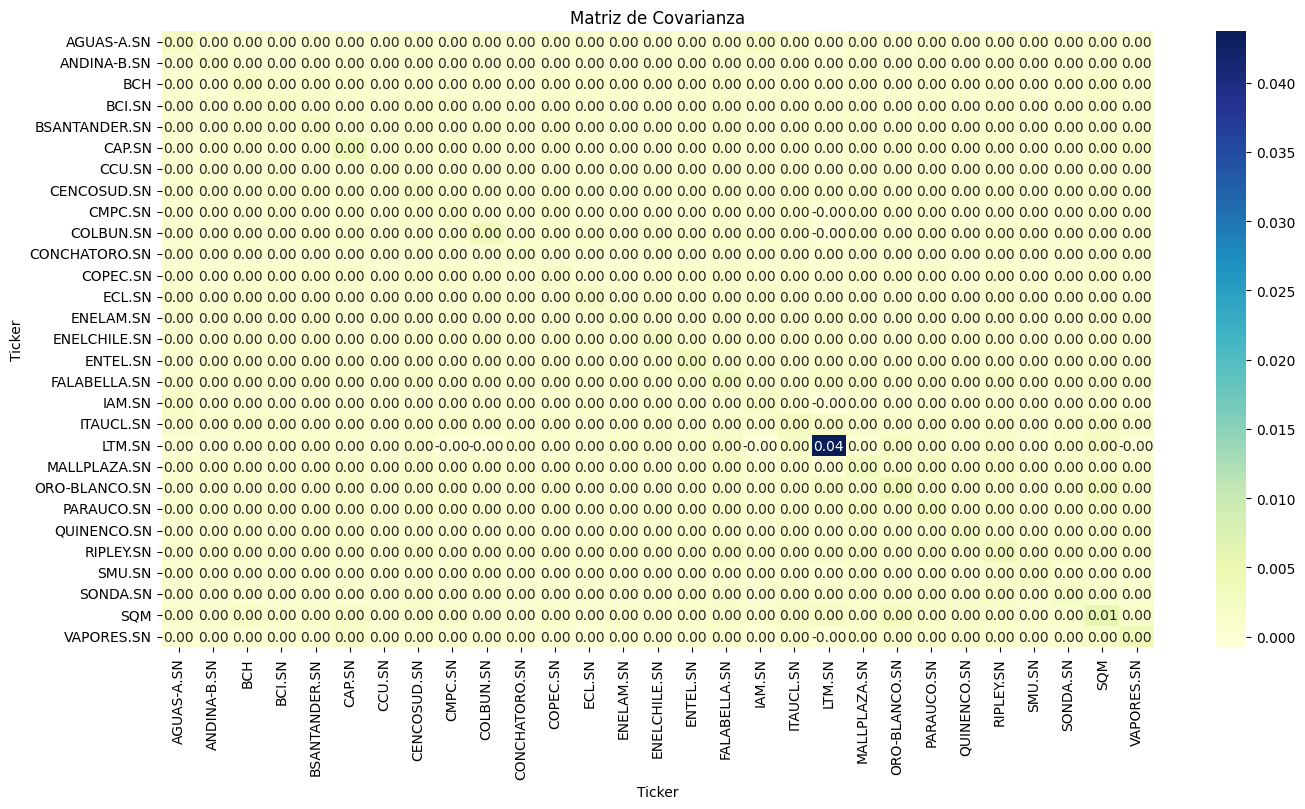

In [17]:
# La matriz de covarianza de los rendimientos semanales.

weekly_covariance_matrix = weekly_returns.cov()

# Heatmap de la Matriz de Covarianza

plt.figure(figsize=(16, 8))
sns.heatmap(weekly_covariance_matrix, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Matriz de Covarianza")
plt.show()


In [18]:
# La volatilidad histórica (desviación estándar) de los rendimientos semanales para cada activo.

weekly_covariance_matrix = weekly_returns.cov()


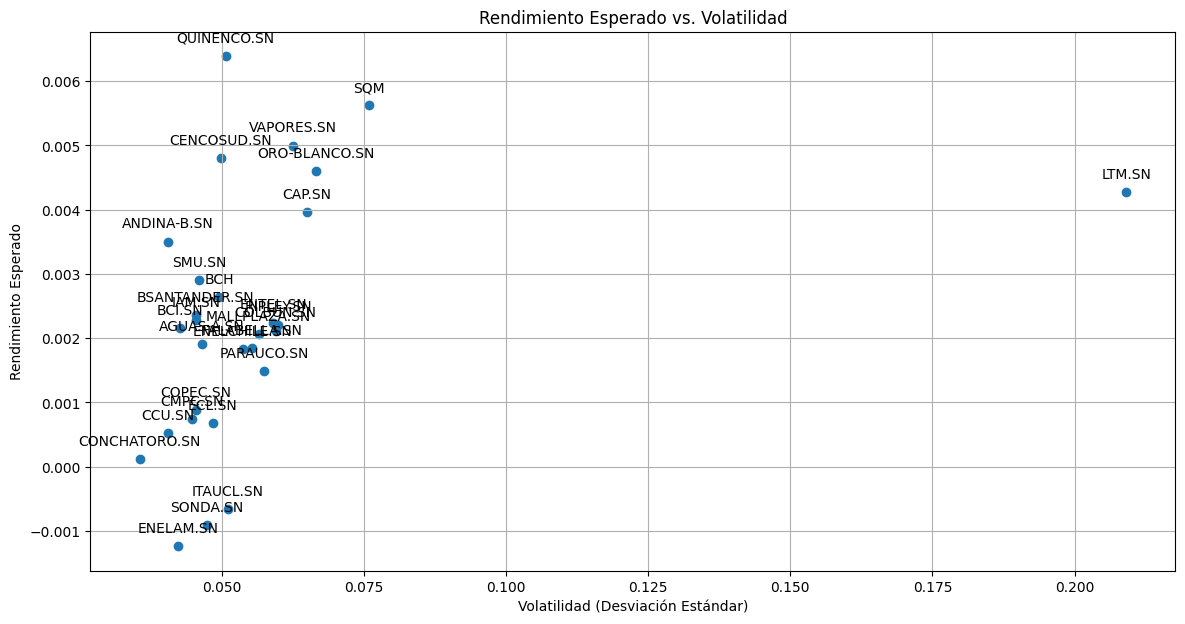

In [19]:
# Rendimiento Esperado vs. Volatilidad (Riesgo)

# Calculo de los rendimientos semanales
weekly_returns = prices.pct_change().dropna()

# Calculo del rendimiento esperado (media) para cada activo
expected_weekly_returns = weekly_returns.mean()
weekly_volatilities = weekly_returns.std()

plt.figure(figsize=(14,7))
plt.scatter(weekly_volatilities, expected_weekly_returns, marker='o')
plt.xlabel('Volatilidad (Desviación Estándar)')
plt.ylabel('Rendimiento Esperado')
plt.title('Rendimiento Esperado vs. Volatilidad')

for label, x, y in zip(weekly_returns.columns, weekly_volatilities, expected_weekly_returns):
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()


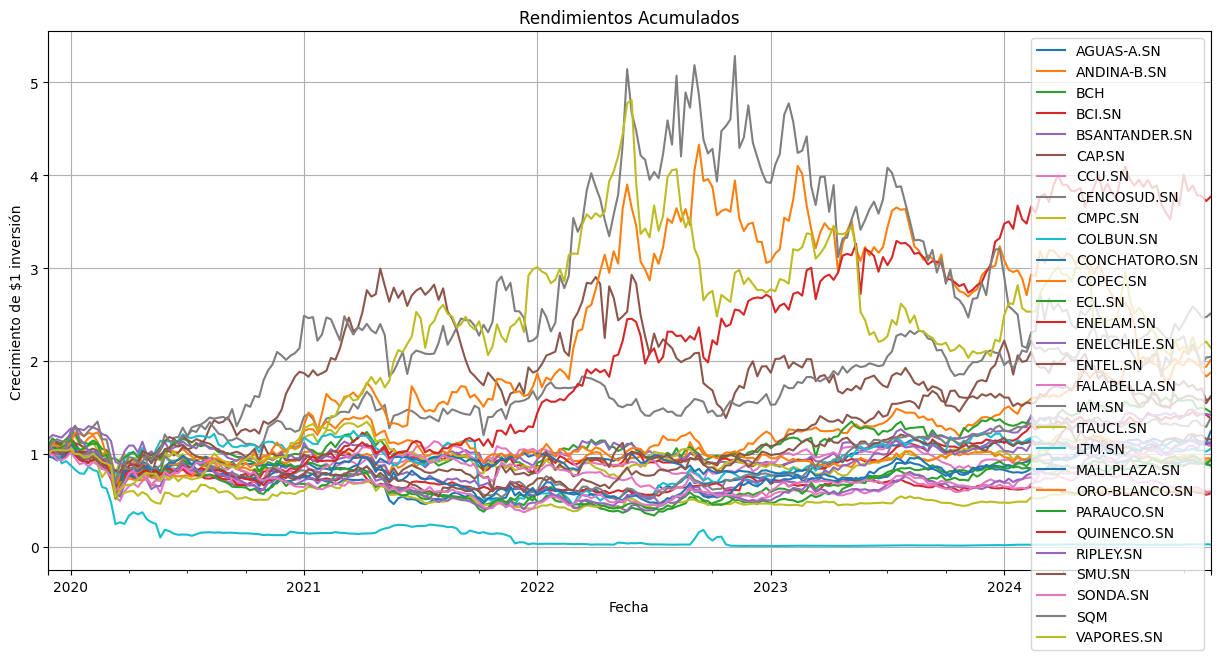

In [20]:
# Serie Temporal de Rendimientos Acumulados: ¿cómo ha crecido (o decrecido) una inversión unitaria en cada activo a lo largo del tiempo?

(1 + weekly_returns).cumprod().plot(figsize=(15, 7))
plt.title('Rendimientos Acumulados')
plt.xlabel('Fecha')
plt.ylabel('Crecimiento de $1 inversión')
plt.grid(True)
plt.legend()
plt.show()


## Optimización:

- Utilizar algoritmos de optimización (como el optimizador de Markowitz) para encontrar la combinación óptima de activos en la cartera.
- Si es necesario, incluir restricciones en la optimización.
- Graficar la frontera eficiente si el objetivo es equilibrar rentabilidad y riesgo.

In [21]:
# Rendimientos y covarianza
mean_returns = weekly_returns.mean()
cov_matrix = weekly_returns.cov()

# Número de activos
num_assets = len(mean_returns)

# Pesos iniciales: Distribución equitativa
initial_weights = [1./num_assets for _ in range(num_assets)]

# Función objetivo (negativo del Sharpe Ratio)
def objective(weights): 
    portfolio_return = np.dot(mean_returns, weights)
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_stddev

# Restricciones y límites
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(num_assets))


In [22]:
solution = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = solution.x


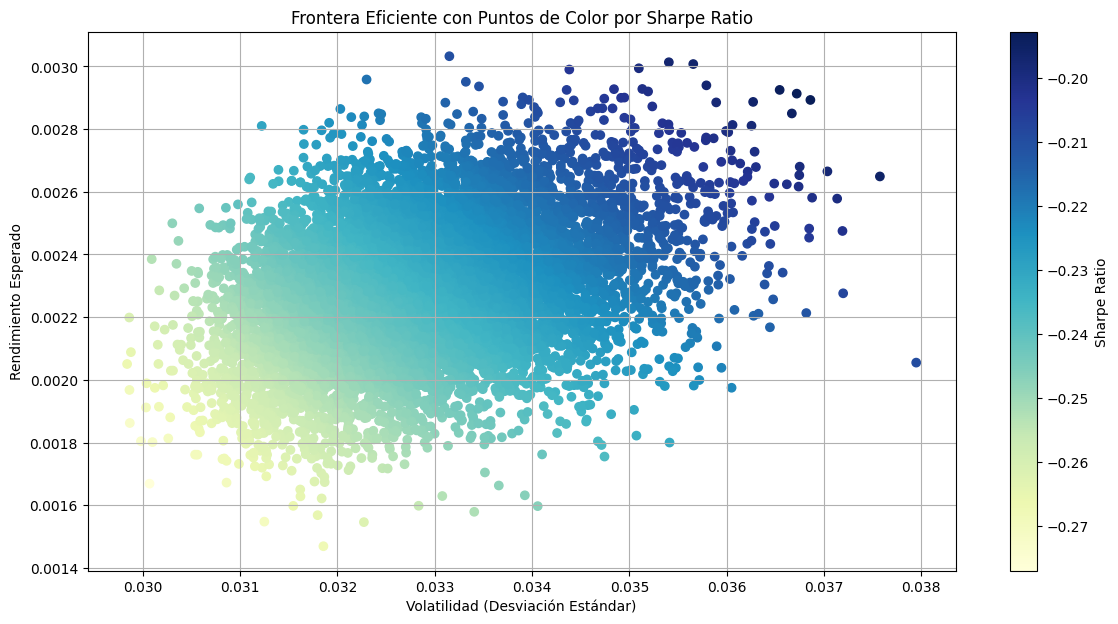

In [23]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(mean_returns, weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return std, returns

def efficient_frontier(mean_returns, cov_matrix, num_portfolios=10000):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_stddev, portfolio_return = portfolio_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_stddev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_stddev
    return results, weights_record

risk_free_rate = 0.01  # asumamos una tasa libre de riesgo del 1%
results, _ = efficient_frontier(mean_returns, cov_matrix)

plt.figure(figsize=(14,7))
plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o')
plt.title('Frontera Eficiente con Puntos de Color por Sharpe Ratio')
plt.xlabel('Volatilidad (Desviación Estándar)')
plt.ylabel('Rendimiento Esperado')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()


In [24]:
# Función objetivo para minimizar (-Sharpe Ratio)
def objective(weights): 
    portfolio_return = np.dot(mean_returns, weights)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Restricciones y límites
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for asset in range(len(mean_returns)))

# Optimización
initial_weights = [1./len(mean_returns) for _ in mean_returns]
solution = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

# Extraer resultados
optimal_weights = solution.x
expected_portfolio_return = np.dot(mean_returns, optimal_weights)
expected_portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
sharpe_ratio = expected_portfolio_return / expected_portfolio_volatility

print("Pesos óptimos:", optimal_weights)
print("Rendimiento esperado de la cartera:", expected_portfolio_return)
print("Volatilidad de la cartera:", expected_portfolio_volatility)
print("Ratio de Sharpe:", sharpe_ratio)


Pesos óptimos: [9.30553218e-17 2.03961192e-01 0.00000000e+00 4.81060140e-17
 0.00000000e+00 6.07519462e-17 0.00000000e+00 1.89951098e-01
 0.00000000e+00 7.94273126e-17 5.31221609e-17 4.99530329e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.48165841e-03
 6.01856773e-17 0.00000000e+00 5.08726368e-17 4.35616202e-01
 1.68693197e-17 5.81952798e-02 1.05787864e-16 4.21911881e-02
 6.16033827e-02]
Rendimiento esperado de la cartera: 0.005160422477406542
Volatilidad de la cartera: 0.03608560783502622
Ratio de Sharpe: 0.1430050035736856


## Evaluación de Desempeño:

- Medir el rendimiento de la cartera optimizada usando métricas como el Sharpe Ratio, Sortino Ratio, etc.
- Comparar el rendimiento con un benchmark o índice de referencia.

Benchmark de Cartera Equilibrada: Comienza por comparar el desempeño de tu cartera optimizada con una cartera equilibrada, donde cada acción tiene el mismo peso (1/n, donde n es el número de acciones). Esta comparación te dará una idea de cómo se comporta tu cartera optimizada frente a una estrategia de diversificación simple.

In [25]:
# Peso igual para cada acción
num_stocks = len(tickers)
equal_weights = np.array([1./num_stocks for _ in range(num_stocks)])

# Calcular rendimiento y volatilidad de la cartera equilibrada
equal_weighted_return = weekly_returns.dot(equal_weights).mean()
equal_weighted_volatility = np.sqrt(np.dot(equal_weights.T, np.dot(weekly_returns.cov(), equal_weights)))

print(f"Rendimiento esperado de la cartera equilibrada: {equal_weighted_return}")
print(f"Volatilidad de la cartera equilibrada: {equal_weighted_volatility}")

Rendimiento esperado de la cartera equilibrada: 0.0022864703933681493
Volatilidad de la cartera equilibrada: 0.03224140424995484


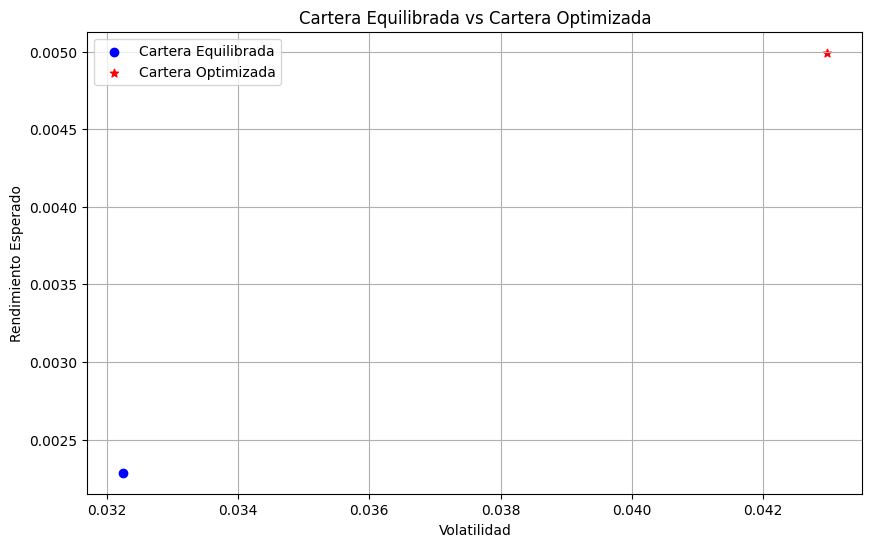

In [26]:
plt.figure(figsize=(10,6))
plt.scatter(equal_weighted_volatility, equal_weighted_return, color='blue', marker='o', label='Cartera Equilibrada')
plt.scatter(0.04297543230327296, 0.0049923967249856736, color='red', marker='*', label='Cartera Optimizada')
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento Esperado')
plt.title('Cartera Equilibrada vs Cartera Optimizada')
plt.legend()
plt.grid(True)
plt.show()


/home/makabrus/Workspace/OptimizacionDeCarteras/env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
[*********************100%***********************]  1 of 1 completed


<Figure size 1400x700 with 0 Axes>

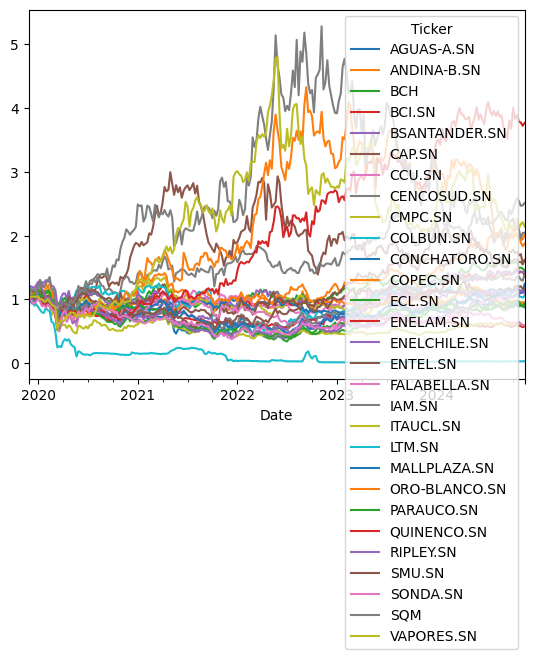

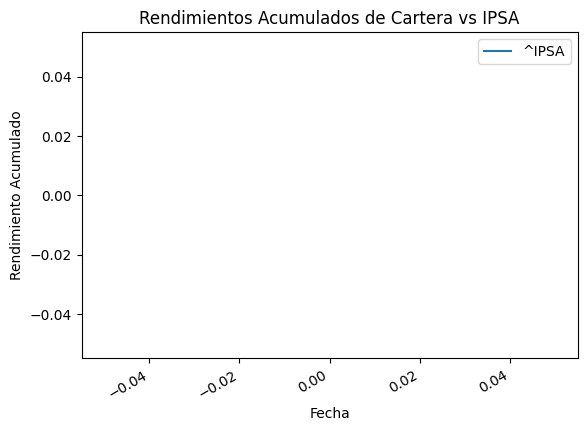

In [27]:
# Retornos semanales de la cartera calculados
returns_cartera = prices.pct_change().dropna()

# Cálculo de Sortino Ratio
rendimiento_libre_riesgo = 0.0002  # Suponemos un rendimiento semanal de un activo libre de riesgo. Debes ajustar este valor según tus datos.
returns_negativos = returns_cartera[returns_cartera < 0]
volatilidad_negativa = np.std(returns_negativos)
sortino_ratio = (np.mean(returns_cartera) - rendimiento_libre_riesgo) / volatilidad_negativa

# Descarga de datos del índice IPSA
data_ipsa = yf.download("^IPSA", start=start_date, end=end_date, interval="1wk")
returns_ipsa = data_ipsa['Adj Close'].pct_change().dropna()

# Grafica de rendimientos acumulados
plt.figure(figsize=(14,7))
(1 + returns_cartera).cumprod().plot(label='Cartera Optimizada')
(1 + returns_ipsa).cumprod().plot(label='IPSA')
plt.title('Rendimientos Acumulados de Cartera vs IPSA')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento Acumulado')
plt.legend()
plt.show()


La cartera optimizada parece ser una mejor elección si el inversor está dispuesto a aceptar un poco más de riesgo (dada la mayor volatilidad) a cambio de un rendimiento significativamente más alto. Sin embargo, es esencial recordar que todos estos cálculos se basan en datos históricos, y como tal, no garantizan rendimientos futuros. Es crucial considerar otros factores y posiblemente consultar a un asesor financiero antes de tomar decisiones de inversión.

In [28]:
# Definir el rendimiento del activo sin riesgo (puede variar según el instrumento o país)
risk_free_rate = 0.001 / 100  # 0.001% semanal convertido a decimal

# Calcular el Ratio de Sharpe para la cartera equilibrada
sharpe_ratio_equilibrada = (0.0008960912526867234 - risk_free_rate) / 0.03253042992058013

# Calcular el Ratio de Sharpe para la cartera optimizada
# Suponiendo que ya tienes el rendimiento y volatilidad de la cartera optimizada
sharpe_ratio_optimizada = (0.0049923967249856736 - risk_free_rate) / 0.04297543230327296

print(f"Ratio de Sharpe para la cartera equilibrada: {sharpe_ratio_equilibrada}")
print(f"Ratio de Sharpe para la cartera optimizada: {sharpe_ratio_optimizada}")


Ratio de Sharpe para la cartera equilibrada: 0.027238842365441485
Ratio de Sharpe para la cartera optimizada: 0.1159359303200359


La cartera optimizada muestra un ratio de Sharpe de 0.1159, superando ampliamente el 0.0272 de la cartera equilibrada. Esto indica que la cartera optimizada proporciona un exceso de rendimiento mayor por cada unidad de riesgo, en comparación con la equilibrada. En términos simples, a pesar de asumir más volatilidad, la cartera optimizada ha compensado con un rendimiento superior, siendo una opción más atractiva para inversores que usen el ratio de Sharpe como métrica de referencia.

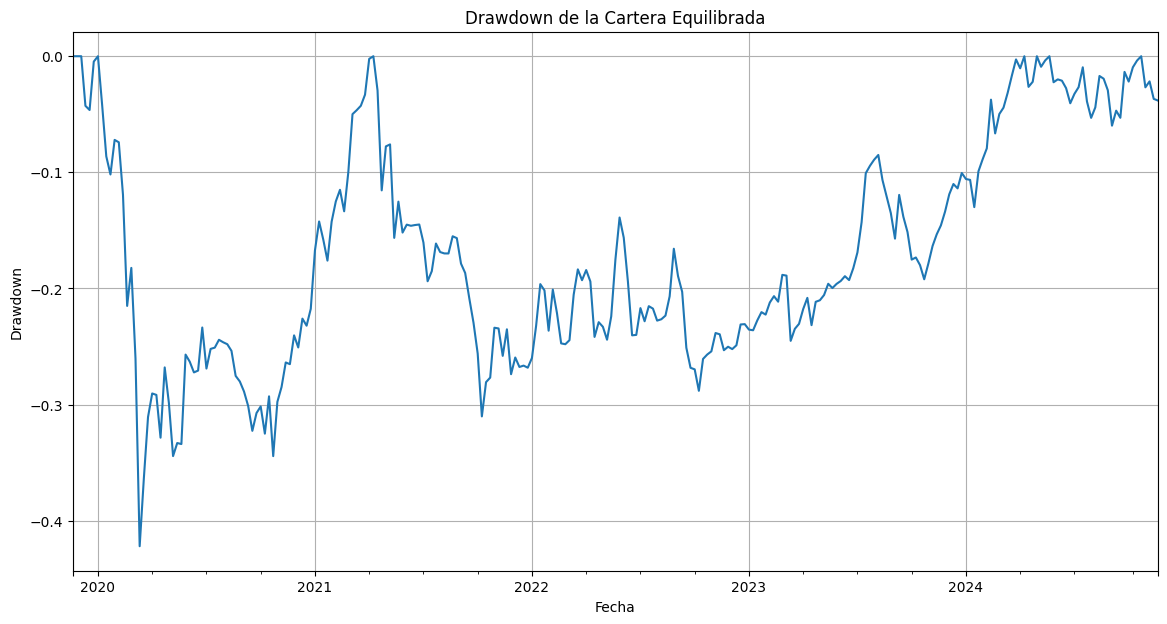

In [29]:
# Análisis de Drawdown

def compute_drawdowns(prices):

    # Calcula la serie de máximos históricos
    rolling_max = prices.expanding().max()
    
    # Calcula el drawdown
    drawdowns = (prices - rolling_max) / rolling_max
    
    return drawdowns

# Calcula el drawdown para la cartera equilibrada
equally_weighted_portfolio = prices.dot(np.ones(len(tickers)) / len(tickers))
drawdown_equally_weighted = compute_drawdowns(equally_weighted_portfolio)

# Grafica el drawdown
plt.figure(figsize=(14,7))
drawdown_equally_weighted.plot()
plt.title('Drawdown de la Cartera Equilibrada')
plt.xlabel('Fecha')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()


La cartera experimentó su mayor caída, un Máximo Drawdown del 54.72%, entre el 28 de enero de 2019 y el 16 de marzo de 2020, tardando 413 días en recuperarse. En promedio, las caídas desde los picos fueron del 30.04%. Esta información sugiere periodos significativos de bajo rendimiento y destaca la necesidad de revisar la estrategia de inversión para mejorar la resistencia frente a caídas del mercado.

## Implementación y Monitoreo:

- Implementar la estrategia de inversión propuesta.
- Monitorear y reevaluar la cartera periódicamente.
- Rebalancear si es necesario basándose en cambios en las condiciones del mercado o en los objetivos del inversionista.

In [30]:
# Evaluar la inversion de 1 millon de CLP 

pd.set_option('display.float_format', lambda x: '%.2f' % x)

monto_inversion = 1000000  # 1 millon de CLP

# Calcular la inversión por ticker
inversion_por_ticker = [monto_inversion * peso/100 for peso in pesos_porcentajes]

df_inversion_sorted = df_inversion.sort_values(by="Inversión en CLP", ascending=False)

print(df_inversion_sorted)


NameError: name 'pesos_porcentajes' is not defined

La optimización propuesta sugiere que, al invertir 1 millón de CLP, se debe asignar una cantidad significativa a las acciones de ECL.SN, RIPLEY.SN, SMU.SN y CMPC.SN, y un monto mínimo en ORO-BLANCO.SN. Las demás acciones no recibirían inversión.

A corto plazo: La cartera optimizada apunta a aprovechar los movimientos de precio y rendimientos más inmediatos de los activos seleccionados. Sin embargo, es importante recordar que la volatilidad puede ser alta en períodos cortos, y las decisiones de inversión deberían basarse también en acontecimientos actuales del mercado y análisis técnico.

A mediano plazo: Las asignaciones en la cartera reflejan una estrategia de balance entre rendimiento y riesgo. Aunque las acciones como ECL.SN y RIPLEY.SN dominan la inversión, tener presencia en SMU.SN y CMPC.SN proporciona diversificación. Es una estrategia adecuada para inversores que buscan crecimiento pero con cierto grado de protección contra la volatilidad.

A largo plazo: La composición de esta cartera puede ser una base sólida, pero el rebalanceo periódico es esencial. Las condiciones del mercado, los fundamentales de las empresas y los eventos macroeconómicos cambian. Por lo tanto, es vital revisar y ajustar la asignación de activos con el tiempo para seguir alineados con los objetivos y mantener una cartera optimizada.

## Documentación y Presentación:

- Documentar el proceso, las decisiones tomadas y los resultados obtenidos.
- Crear visualizaciones y presentaciones para stakeholders o clientes.
- Automatización (Eso hemos Realizado)